<a href="https://colab.research.google.com/github/Sourabhpatel1/Capstone-Project-EDA-AlmaBatter/blob/main/Capstone_Project_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing required libraries

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (15,8)

In [3]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Loading the Dataser

data = pd.read_csv('/content/drive/MyDrive/Capstone Project - 2/SeoulBikeData.csv',encoding='unicode_escape', parse_dates=["Date"])

In [5]:
# Checking Shape of the dataset

data.shape

(8760, 14)

In [6]:
# Checking Head of the DataSet

data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [7]:
# Checking Tail of the DataSet

data.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,2018-11-30,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [8]:
# Checking for missing data and type of data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

In [9]:
# Checking quick stats with describe

data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [10]:
# checking categorical columns

data.describe(include='object')

,Seasons,Holiday,Functioning Day
count,8760,8760,8760
unique,4,2,2
top,Summer,No Holiday,Yes
freq,2208,8328,8465


In [11]:
# functioning day specifies whether bikes were available for rent on that day or not.
# We are not interedted in rows where rented bike count was 0 hence removing those rows

data = data[data["Functioning Day"] != "No"]

# Checking Data Shape Again

data.shape

(8465, 14)

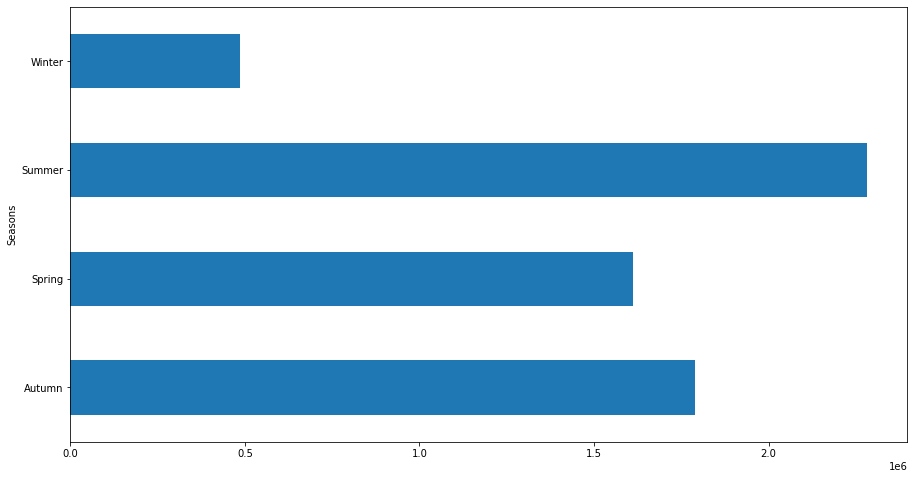

In [12]:
# Number of Rows Reduced from 8760 to 8465 i.e. 295 rows where rented bike count was 0 were removed
# Examing the categorical columns closer

# cheking Seasons Feature

data.groupby("Seasons").sum()["Rented Bike Count"].plot(kind='barh')

# Rented Bikes are more in demand during summers and lowest during winters and demand is evenly distributed between spring and autumn

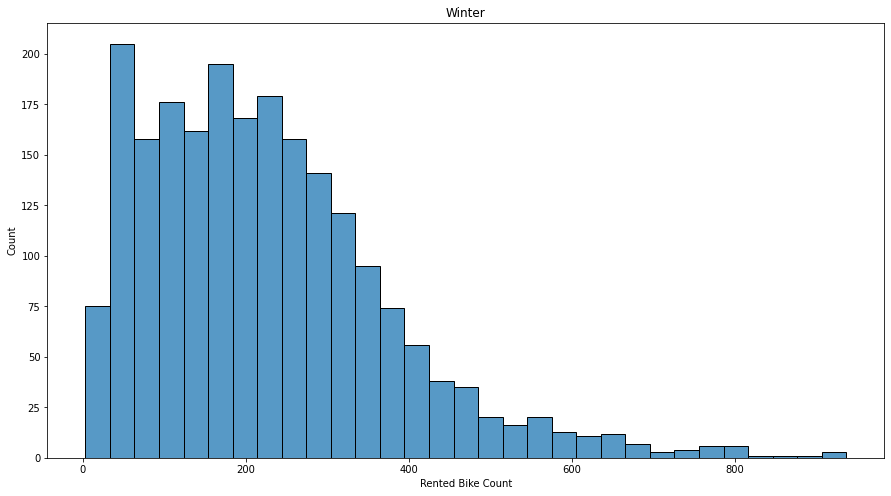

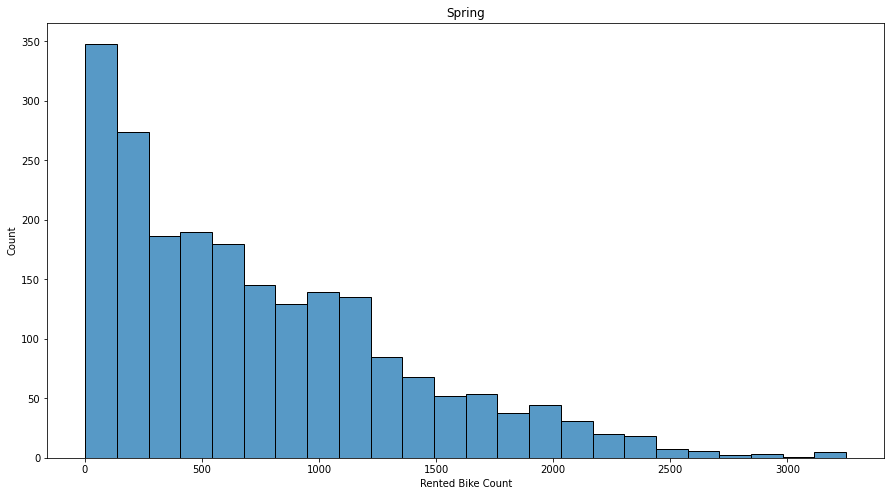

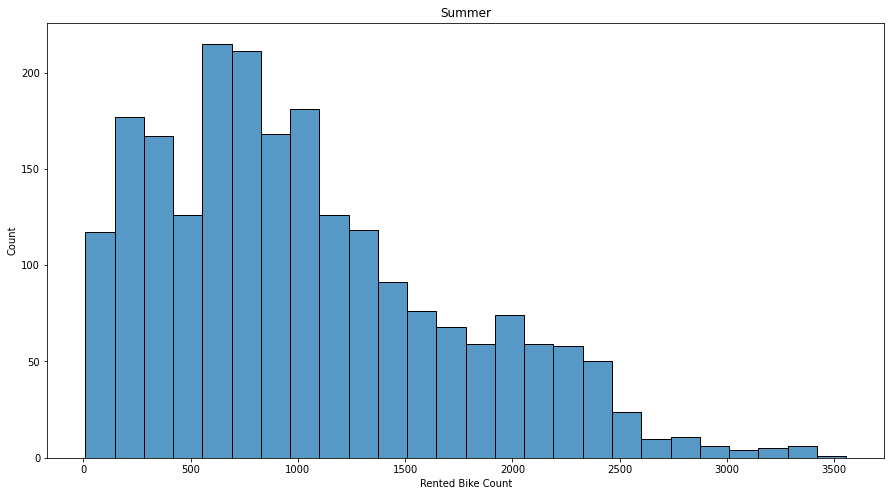

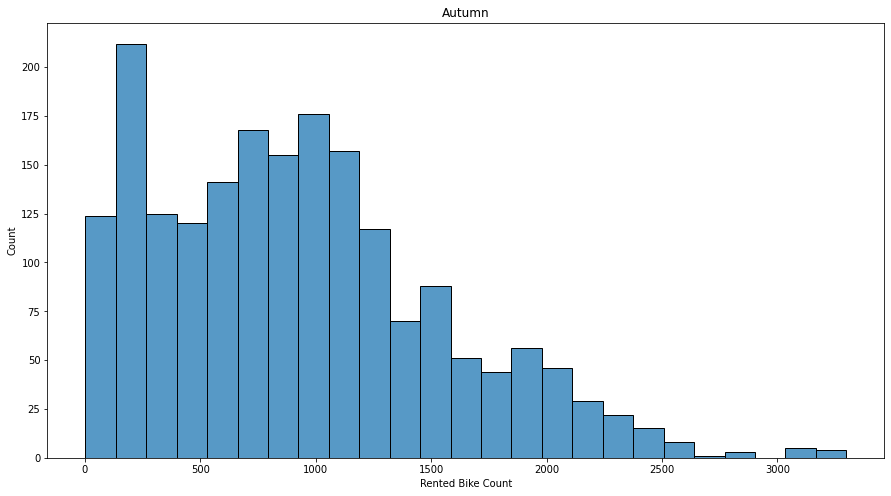

In [13]:
for i, season in enumerate(data["Seasons"].unique()):
  plt.figure(i)
  plt.title(label=season)
  sns.histplot(data[data["Seasons"] == season]["Rented Bike Count"])

# The distribution across seasons is almost similar with minor variations The rental data seems to be left skewed or positively skewed

In [14]:
# Looking at effect of Holiday on Bike Rentals 
data.groupby("Holiday").mean()["Rented Bike Count"]

# People tend to rent lesser number of bikes during holidays
# We have Already dropped the non functioning day rows so we should also drop the column as well

Holiday
Holiday       529.154412
No Holiday    739.284970
Name: Rented Bike Count, dtype: float64

In [15]:
data.drop("Functioning Day", axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


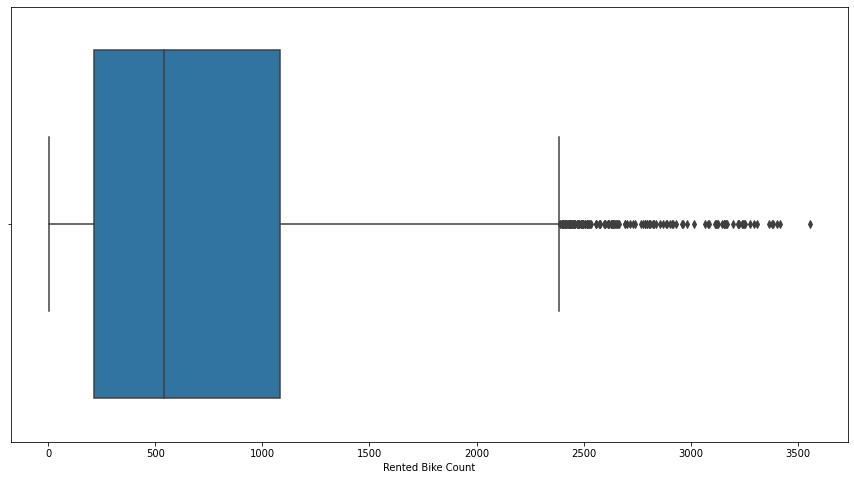

In [16]:
# Our Dependent Variable is Rented Bike Count so we should Check for Outliers
# Checking for Outliers in Rented Bike Count

sns.boxplot(data["Rented Bike Count"])

# There are lots of dots outside the upper whisker so we should check for the upper bound outliers

In [17]:
# Defining upper Bound
IQR = np.quantile(data["Rented Bike Count"], 0.75) - np.quantile(data["Rented Bike Count"], 0.25)
upper_bound = np.quantile(data["Rented Bike Count"], 0.75) + (1.5 * IQR)
print(upper_bound)

2389.0


In [18]:
# Looking at rows above upper bound
data[data["Rented Bike Count"] > 2389].shape

# There are 152 rows where the rented bike  count exceeds upper bound 152 rows is approximately 1.80% hence we drop the outliers

(152, 13)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


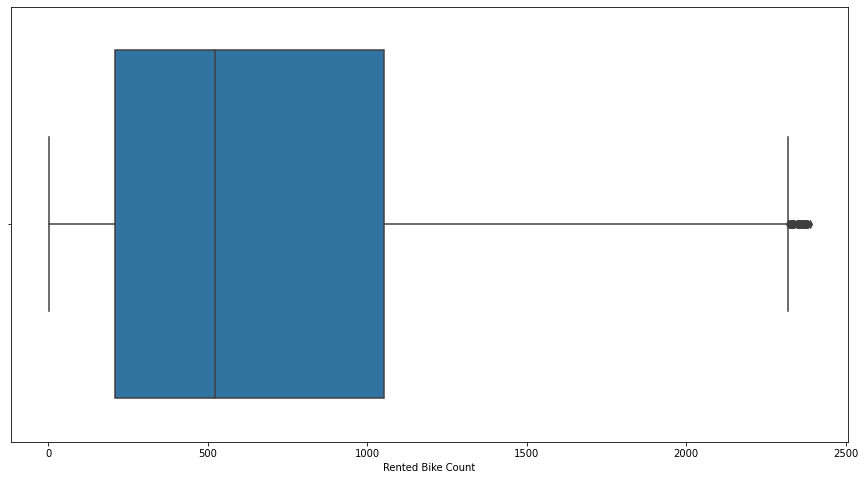

In [19]:
# dropping rows where Rented Bike Count is more than the upper bound
data = data[data["Rented Bike Count"] < upper_bound]

# Plotting to see if there are still any outliers
sns.boxplot(data["Rented Bike Count"])

In [20]:
# There are few points but they are very close to the upper Bound and hence we keep those
# Assumption of Linear Regression is Normally distributed data, Correlation Between dependent and Independent Variables and No multicolinearity
# We should check for Correlation of the dataset
# We should then check for correlation between Independent Variables to reduce the number of features.
# We should also check for the Distribution of the columsn to see if they follow a gausian distribution
# If they are not normally distributed then we may need to do some sort of transformation on them

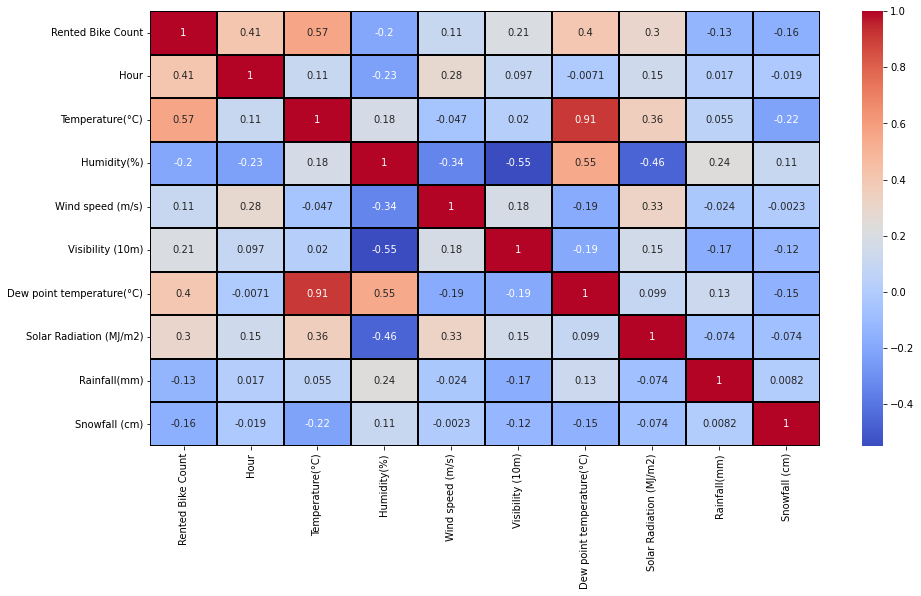

In [21]:
# Checking for correlation in the df
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, linewidths=1, linecolor="black")

# The Categorical features are not included in the matrix we should encode the categorical features to check for correlation better
# Also dates are not represented in the dataset we should include dates somehow.

In [22]:
# Converting dates to useful features.
# 1. Taking the month of the year as an integer from the date column
data["Month"] = data["Date"].apply(lambda x : x.month)
data.head()

# we can see the new feature added as the last column

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,1
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,1
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,1
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,1
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,1


In [23]:
# Taking day of the week as an ordinal feature to see how the day of the week influences bike rentals

data["Day of Week"] = data["Date"].apply(lambda x : x.weekday())
data

# we can see the new feature added as the last column
# Year doesnt seem relevant as there are only 2 years in the whole dataset

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Day of Week
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,1,3
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,1,3
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,1,3
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,1,3
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,11,4
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,11,4
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,11,4
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,11,4


In [24]:
# Encoding Holiday and Seasons to discrete integers
enc = OrdinalEncoder()
enc.fit(data[["Holiday","Seasons"]])
data[["Holiday", "Seasons"]] = enc.transform(data[["Holiday","Seasons"]])

In [25]:
# Checking the new Columns
data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Day of Week
count,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000
mean,692.911584,11.385300,12.560123,58.294599,1.717094,1428.825935,3.785529,0.567528,0.151834,0.079105,1.546253,0.951041,6.489835,3.025983
std,587.635968,6.919853,12.097162,20.577986,1.036166,610.873499,13.285003,0.873978,1.135603,0.447980,1.106920,0.215796,3.477852,1.989699
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,211.000000,5.000000,2.900000,42.000000,0.900000,925.000000,-5.400000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000
50%,522.000000,11.000000,13.000000,57.000000,1.500000,1680.000000,4.500000,0.010000,0.000000,0.000000,2.000000,1.000000,7.000000,3.000000
75%,1054.000000,17.000000,22.400000,74.000000,2.300000,2000.000000,15.000000,0.930000,0.000000,0.000000,3.000000,1.000000,10.000000,5.000000
max,2387.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,3.000000,1.000000,12.000000,6.000000


In [26]:
# now that we have encoded the categorical features and extracted relavant information from dates we should drop the date columns
data.drop("Date", axis=1, inplace=True)
data

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Day of Week
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3.0,1.0,1,3
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3.0,1.0,1,3
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3.0,1.0,1,3
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3.0,1.0,1,3
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3.0,1.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0.0,1.0,11,4
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0.0,1.0,11,4
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0.0,1.0,11,4
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0.0,1.0,11,4


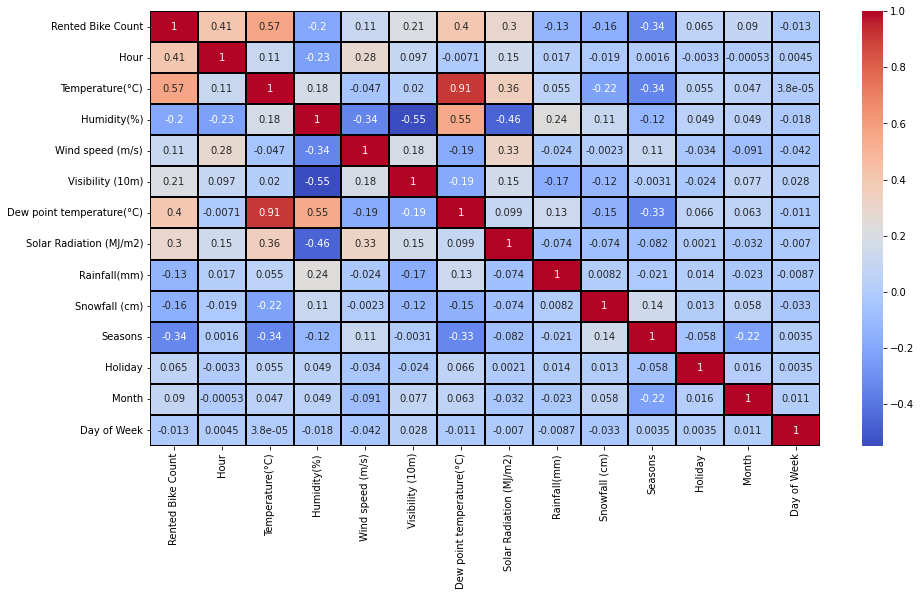

In [27]:
# Now Checking for correlation between the columns
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=1, linecolor='black', annot=True)

In [28]:
# Temprature and Dew Point Temprature are almost perfectly correlated hence we drop dew point temprature
data.drop("Dew point temperature(°C)", axis=1, inplace=True)

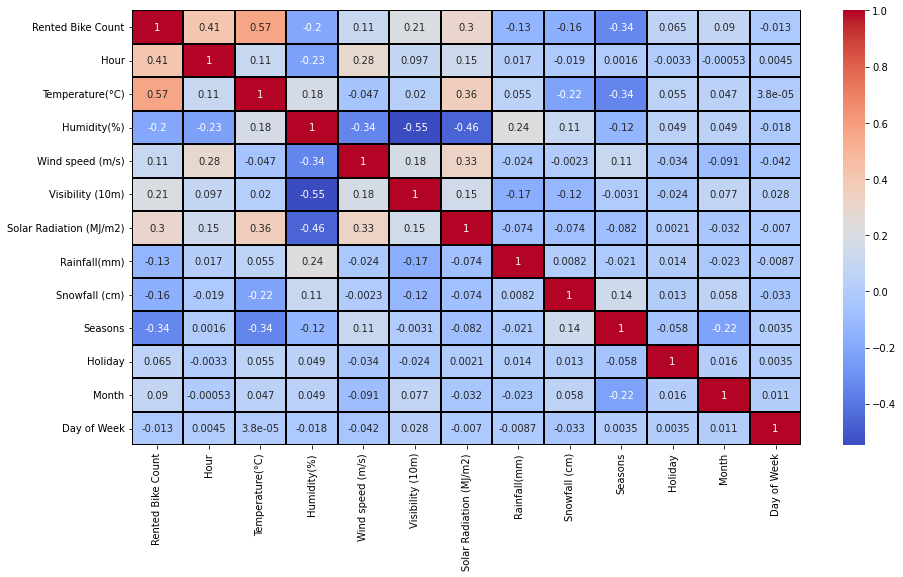

In [29]:
# Checking for correlation again
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=1, linecolor="black", annot=True)

In [30]:
# Fitting and Testing a Baseline Model without any preprocessing of the data

In [31]:
# Building the first simple model
lr_model = LinearRegression()
X = data[[col for col in data.columns if col!= "Rented Bike Count"]]
y = data[["Rented Bike Count"]]


In [32]:
# Splitting the Data

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

In [33]:
# Fitting the Data
lr_model.fit(x_train,y_train)

LinearRegression()

In [34]:
# String predictions in an array
predictions_lr_model = lr_model.predict(x_train)

In [35]:
# Checking the R squared score of the Model
lr_model.score(x_test, y_test)

0.5385402853258826

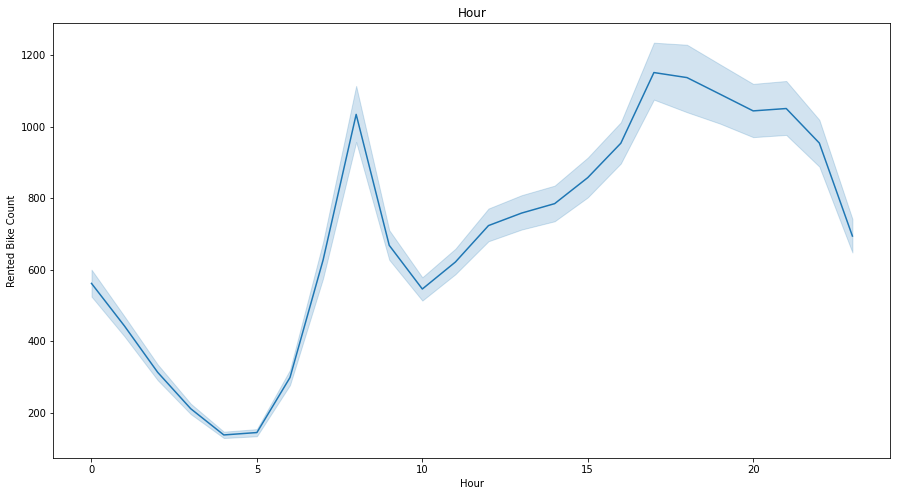

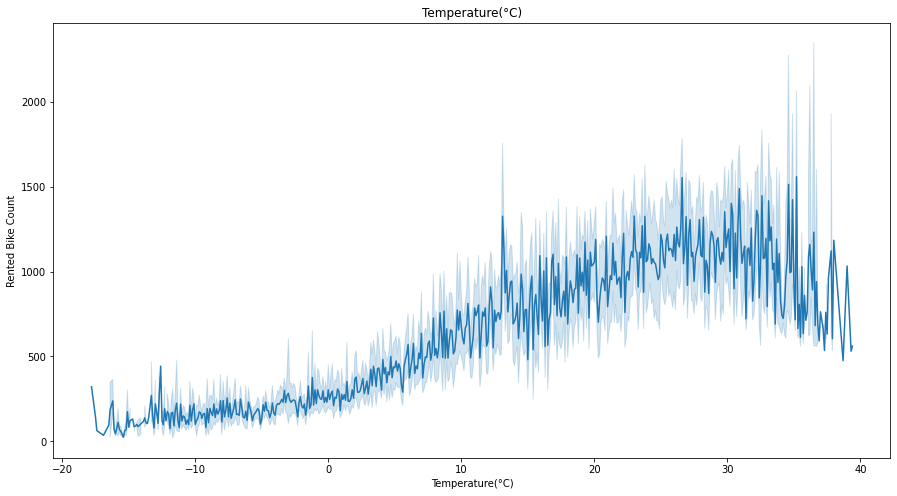

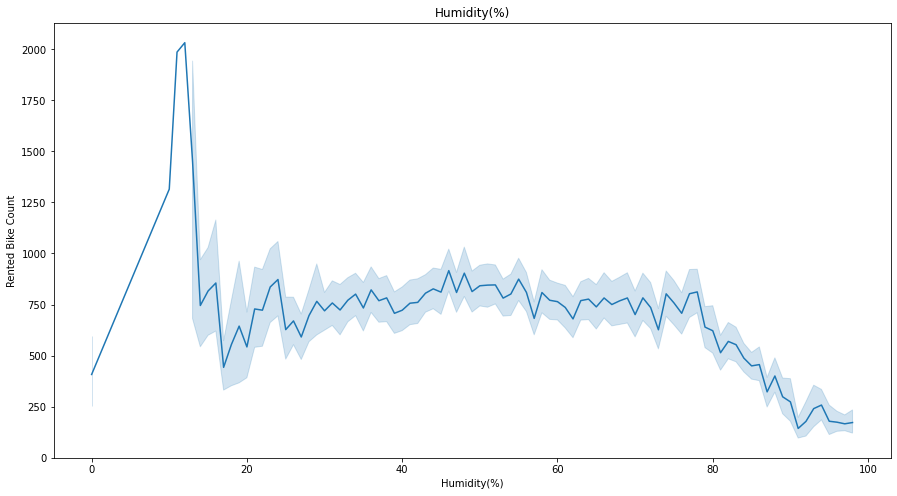

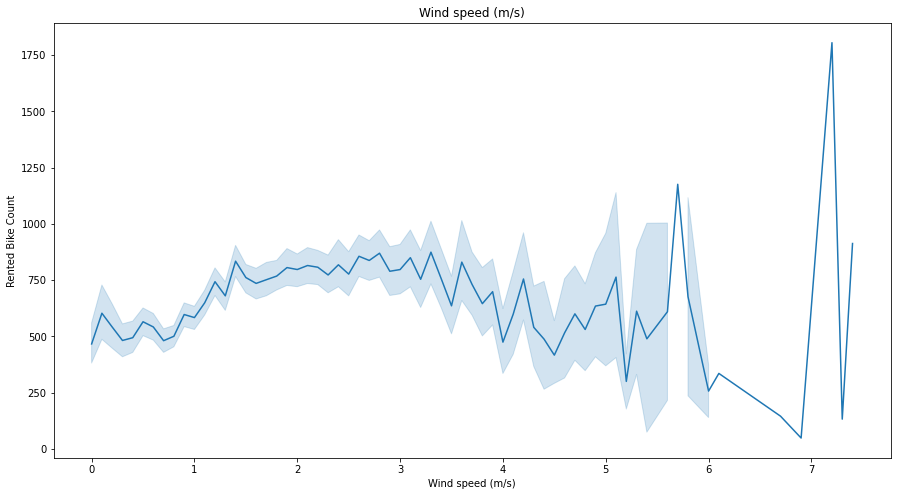

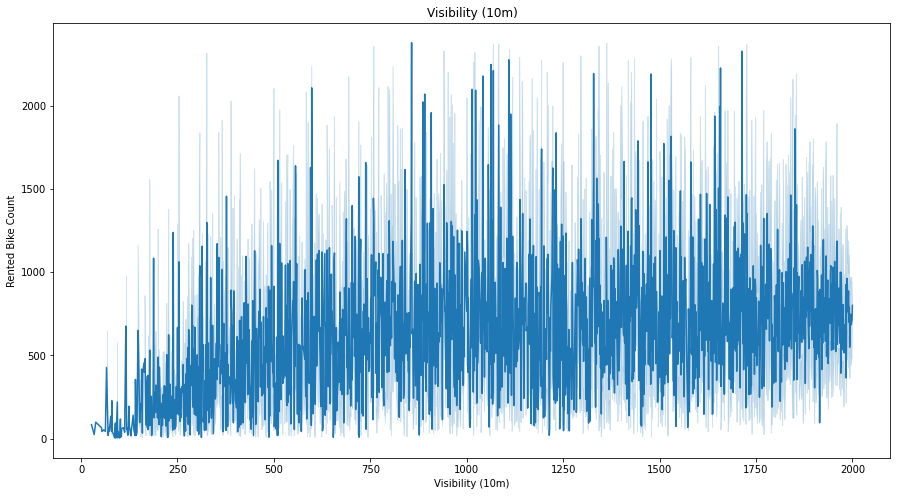

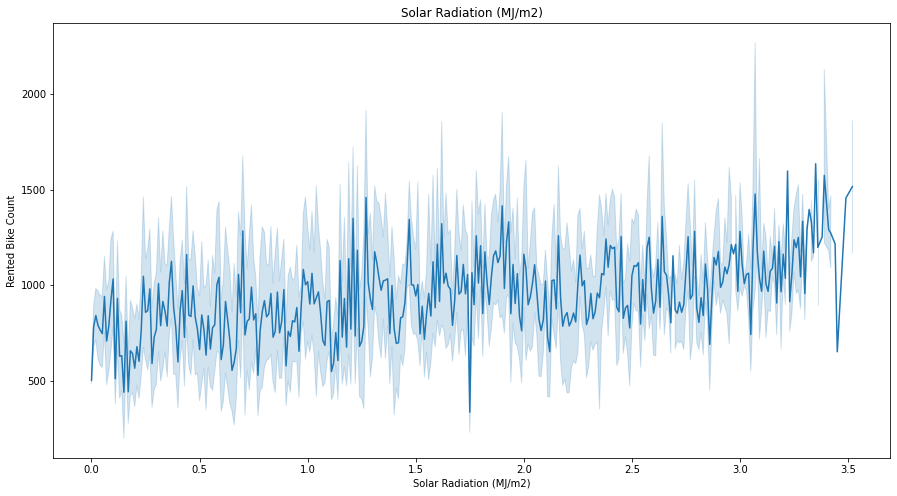

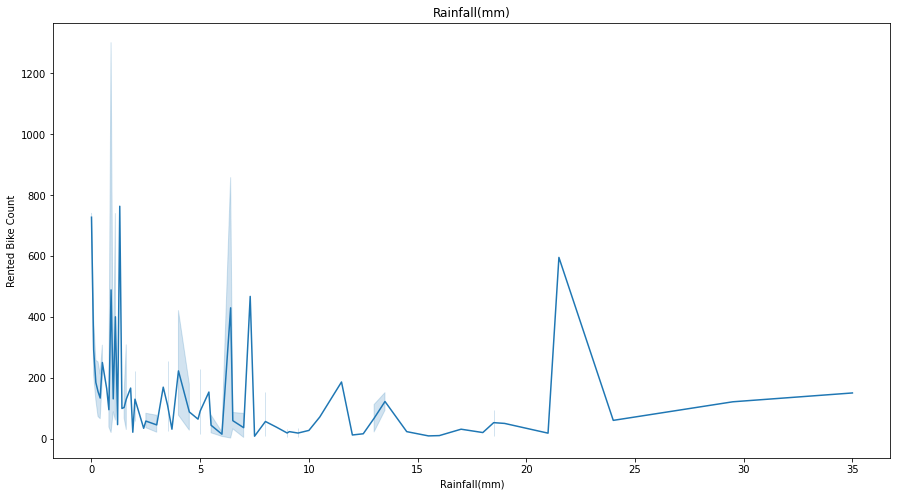

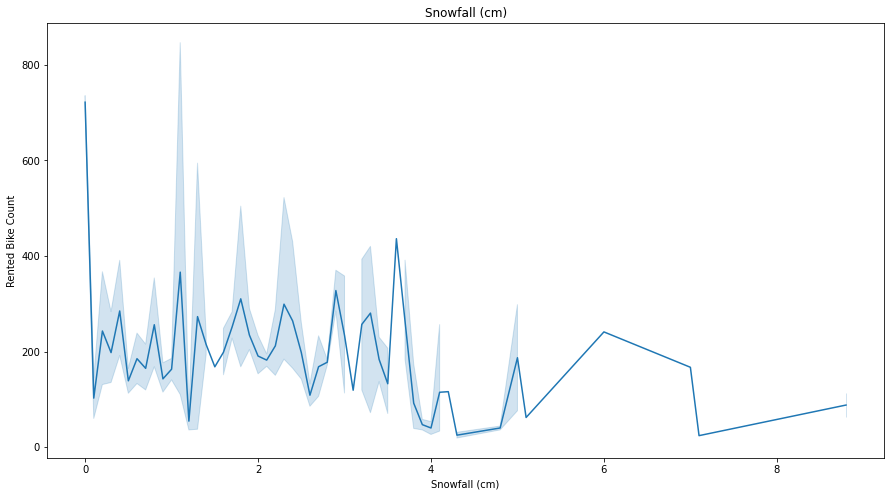

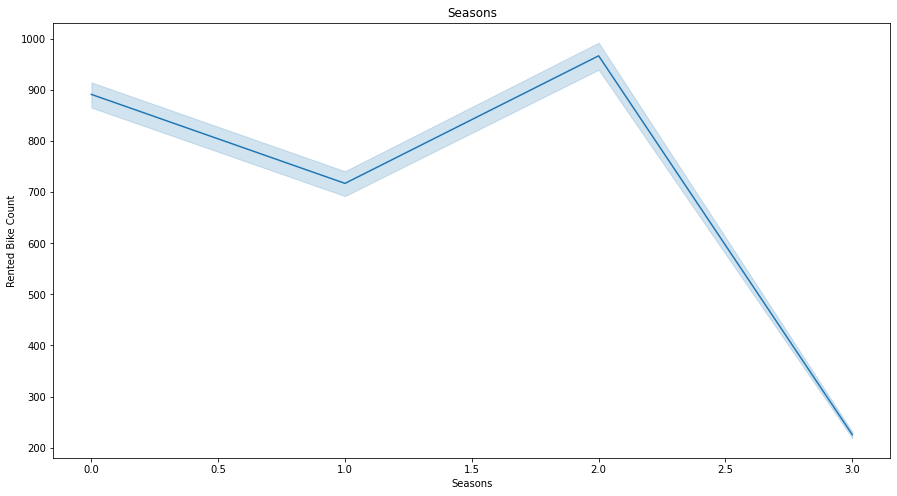

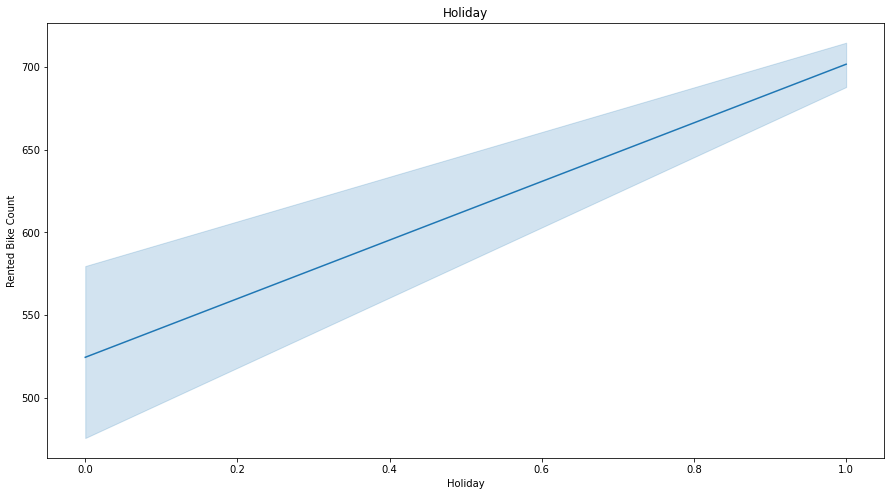

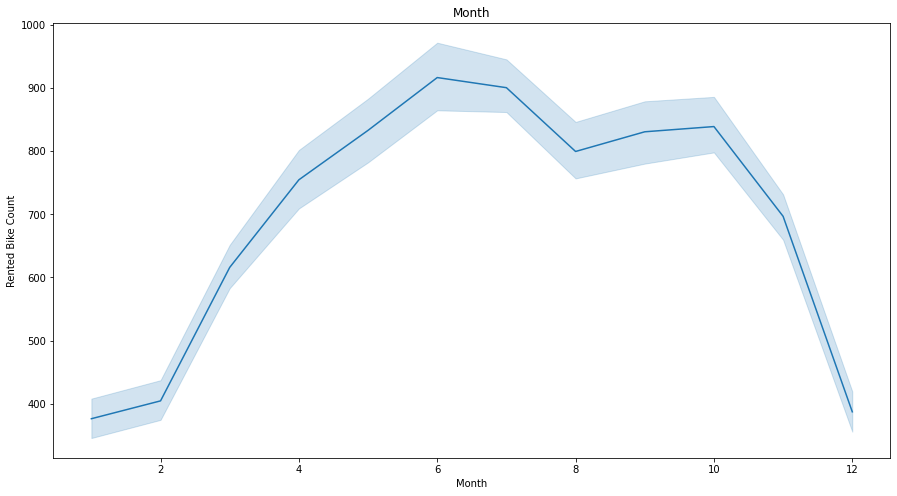

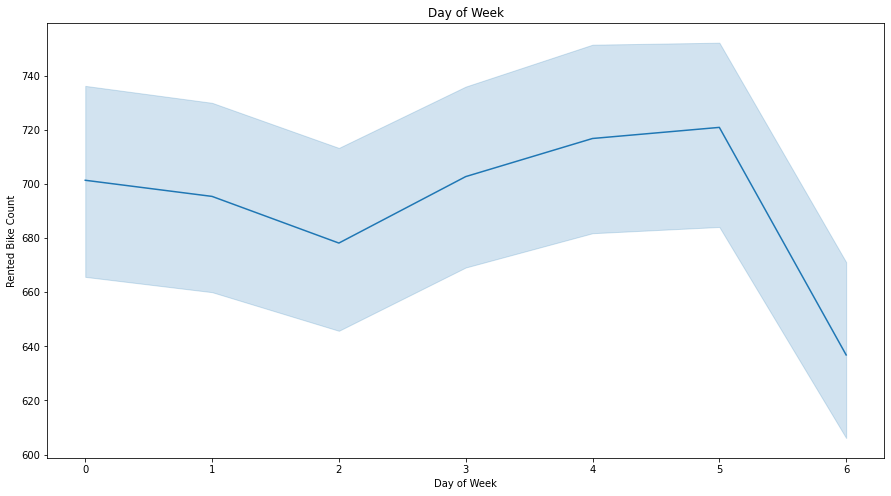

In [36]:
# lets check the distribution of the features and their relationship with the dependent variable
for i, features in enumerate([col for col in data.columns if col != "Rented Bike Count"]):
  plt.figure(i)
  plt.title(label=features)
  sns.lineplot(x=data[features], y=data["Rented Bike Count"])


In [37]:
# Plotting the distribution of colums to check for noraml distributions

In [38]:
data["rainfall_cat"] = data['Rainfall(mm)'].apply(lambda x : 1 if x > 0 else 0)

In [39]:
data['snowfall_cat'] = data['Snowfall (cm)'].apply(lambda x : 1 if x > 0 else 0)

In [40]:
data_new = data.drop(["Rainfall(mm)", "Snowfall (cm)"], axis=1)

In [41]:
X = data_new[[col for col in data_new.columns if col!= "Rented Bike Count"]]
y = data_new[["Rented Bike Count"]]

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=111, test_size = 0.25)

In [43]:
lr_model.fit(x_train, y_train)

LinearRegression()

In [44]:
lr_model.score(x_test, y_test)

0.5521338538333413

In [45]:
# Checking the error on test set
predictions = lr_model.predict(x_test)
print(f"Mean Absolute Error : {mean_absolute_error(predictions, y_test)}")
print(f"Mean Squared Error : {mean_squared_error(predictions, y_test)}")
print(f"R squared score : {lr_model.score(x_test, y_test)}")

Mean Absolute Error : 297.39443016465964
Mean Squared Error : 155163.0486053484
R squared score : 0.5521338538333413


In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Score improves marginally after converting rainfall and snowfall into categorical columns so we keep the columns as categorical

In [48]:
# lets plot the Rented Bike Count to see the shape of its distributions.

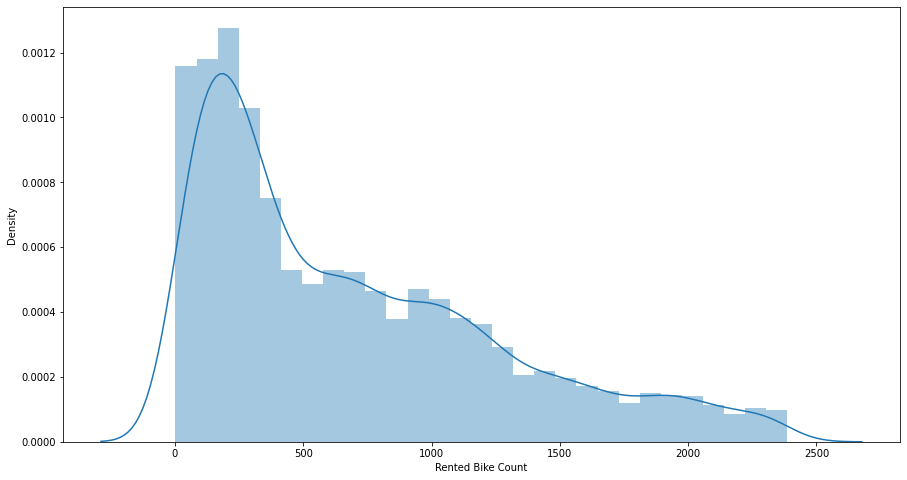

In [49]:
sns.distplot(data_new["Rented Bike Count"])

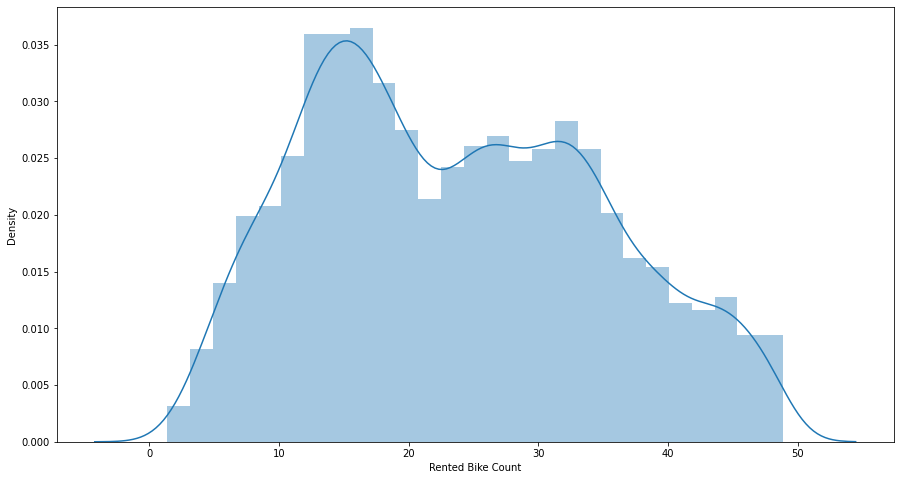

In [50]:
# its bimodal in nature lets try squreroot transformation
sns.distplot(np.sqrt(data_new["Rented Bike Count"]))

In [51]:
# Taking the square root makes the target variable much more normally distributed
# So we transform the target variable by taking square root of the variable and then fitting the model
data_new["Rented Bike Count"] = np.sqrt(data_new["Rented Bike Count"])

In [52]:
# Now lets Try fitting a model and check the r squared score
X, Y = data_new[[col for col in data_new.columns if col != "Rented Bike Count"]], data_new["Rented Bike Count"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=111)

In [53]:
lr_model.fit(x_train, y_train)

LinearRegression()

In [54]:
lr_model.score(x_test, y_test)

0.6244151570456251

In [55]:
# The R2 score has improved significantly by tranforming the data hence we should keep the dataset as it is

In [56]:
# Checking Other metrics for the model.
predictions_lr_model = lr_model.predict(x_test)
print(f"Mean Absolute Error : {mean_absolute_error(predictions_lr_model, y_test)}")
print(f"Mean Squared Error : {mean_squared_error(predictions_lr_model, y_test)}")
print(f"R squared score : {lr_model.score(x_test, y_test)}")

Mean Absolute Error : 5.343638999074267
Mean Squared Error : 48.07170705777897
R squared score : 0.6244151570456251


In [60]:
# Building the Model
# Checking error and r squared score for training set

xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train)
predictions_xgb = xgb_model.predict(x_train)
print(f"Mean Absolute Error : {mean_absolute_error(predictions_xgb, y_train)}")
print(f"Mean Squared Error : {mean_squared_error(predictions_xgb, y_train)}")
print(f"R squared score : {xgb_model.score(x_train, y_train)}")

[12:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 2.7873506310804244
Mean Squared Error : 15.15229148508966
R squared score : 0.8824690728024163


In [61]:
# Checking Scores for test set
predictions_xgb = xgb_model.predict(x_test)
print(f"Mean Absolute Error : {mean_absolute_error(predictions_xgb, y_test)}")
print(f"Mean Squared Error : {mean_squared_error(predictions_xgb, y_test)}")
print(f"R squared score : {xgb_model.score(x_test, y_test)}")

Mean Absolute Error : 3.0432356333949095
Mean Squared Error : 18.48969947435905
R squared score : 0.8555397488796483


In [62]:
# lets try scaling the features to see if the model improves.

scaler = StandardScaler()
data_scaled = data_new.copy()
data_scaled[list(data.columns)] = scaler.fit_transform(data[list(data.columns)])
data_scaled.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Seasons,Holiday,Month,Day of Week,rainfall_cat,snowfall_cat,Rainfall(mm),Snowfall (cm)
0,-0.746956,-1.645408,-1.468211,-1.034886,0.466079,0.935068,-0.649401,1.313405,0.226892,-1.578608,-0.01306,-0.256987,-0.237255,-0.133712,-0.176592
1,-0.832047,-1.500888,-1.493012,-0.986288,-0.885137,0.935068,-0.649401,1.313405,0.226892,-1.578608,-0.01306,-0.256987,-0.237255,-0.133712,-0.176592
2,-0.884804,-1.356368,-1.534347,-0.937689,-0.692106,0.935068,-0.649401,1.313405,0.226892,-1.578608,-0.01306,-0.256987,-0.237255,-0.133712,-0.176592
3,-0.997126,-1.211847,-1.550880,-0.889091,-0.788621,0.935068,-0.649401,1.313405,0.226892,-1.578608,-0.01306,-0.256987,-0.237255,-0.133712,-0.176592
4,-1.046479,-1.067327,-1.534347,-1.083485,0.562594,0.935068,-0.649401,1.313405,0.226892,-1.578608,-0.01306,-0.256987,-0.237255,-0.133712,-0.176592


In [63]:
X, Y = data_scaled[[col for col in data_new.columns if col != "Rented Bike Count"]], data_new["Rented Bike Count"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=111)

In [64]:
xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train)
predictions_xgb = xgb_model.predict(x_train)
print(f"Mean Absolute Error : {mean_absolute_error(predictions_xgb, y_train)}")
print(f"Mean Squared Error : {mean_squared_error(predictions_xgb, y_train)}")
print(f"R squared score : {xgb_model.score(x_train, y_train)}")

[12:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 2.7873506310804244
Mean Squared Error : 15.15229148508966
R squared score : 0.8824690728024163


In [65]:
predictions_xgb = xgb_model.predict(x_test)
print(f"Mean Absolute Error : {mean_absolute_error(predictions_xgb, y_test)}")
print(f"Mean Squared Error : {mean_squared_error(predictions_xgb, y_test)}")
print(f"R squared score : {xgb_model.score(x_test, y_test)}")

Mean Absolute Error : 3.042752059048306
Mean Squared Error : 18.48573332916468
R squared score : 0.8555707364212011


In [66]:
# Scaling did not have any effect on the data so lets try random forest regressor on the data_new to check if the score of the model improves.
X, Y = data_new[[col for col in data_new.columns if col != "Rented Bike Count"]], data_new["Rented Bike Count"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=111)

In [85]:
rf_regressor = RandomForestRegressor(n_estimators=120, max_features=12, max_depth=41)
rf_regressor.fit(x_train, y_train)
predictions_rf = rf_regressor.predict(x_test)
print(f"Mean Absolute Error : {mean_absolute_error(predictions_rf, y_test)}")
print(f"Mean Squared Error : {mean_squared_error(predictions_rf, y_test)}")
print(f"R squared score : {rf_regressor.score(x_test, y_test)}")

Mean Absolute Error : 2.4242227347499563
Mean Squared Error : 13.236378880185379
R squared score : 0.8965840077818796


In [101]:
y = rf_regressor.predict(x_test)**2
print(y)
y1 = y_test.values**2
print(y1)
print(y-y1)

print(np.mean(abs(y-y1)))


[ 619.69384597  530.33445266  479.9012319  ... 1278.88044045 1180.60393043
   79.44918583]
[ 760.  461.  716. ... 1380. 1091.  129.]
[-140.30615403   69.33445266 -236.0987681  ... -101.11955955   89.60393043
  -49.55081417]
121.74108860550118


In [99]:
print(max(y_test**2))

2387.0
